# Classification of Stack Overflow questions

This notebook presents different applications of Machine Learning methods in attempt to classify Stack Overflow-questions into three categories: HQ, LQ_EDIT and LQ_CLOSE. 

The approaches used are Naive Bayes (NB) on a vectorized input of body and body + title and a combination of NB and k-Nearest Neighbors (kNN) as a means of trying to improve the predictions done by NB. 

### Imports
This project uses numpy to handle matrices and vectors, pandas to handle dataframes from the dataset, pyplot to plot results, re to handle regex-strings used to clean the data.
Imports from Scikit-learn are TFidVectorizer used to extract features from text, MultinomialNB which is a naive bayes-approach with more than 2 possible outputs or predictions (unlike BernoulliNB which only handles binary predictions) and KNeighborsClassifier which is the kNN-model used in the project.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import random
import warnings

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

### Dataset
The dataset used is [60k Stack Overflow Questions with Quality Rating](http://www.kaggle.com/imoore/60k-stack-overflow-questions-with-quality-rate). This dataset comes split into a set of training data and validation data, in sizes of respectively 45.000 entries and 15.000 entries. The validation-set is kept separately to maintain a common ground for comparing models and results. 

The three possible classifications, LQ_CLOSE, LQ_EDIT and HQ are mapped to integeres 0-2, and the columns with id and creationdate are dropped as these are not relevant for the task at hand. 

A concatenation of Title and Body is created separately for use when comparing the accuracy between NB-models with additional information. 

As seen in the target value distribution, there is an equal amount of each classification in the dataset, meaning that a random guess-approach will result in about 33.3% accuracy. 

In [2]:
train = pd.read_csv("/kaggle/input/60k-stack-overflow-questions-with-quality-rate/train.csv")
valid = pd.read_csv("/kaggle/input/60k-stack-overflow-questions-with-quality-rate/valid.csv")

data=train.drop(['Id', 'CreationDate'], axis=1)
valid = valid.drop(['Id', 'CreationDate'], axis=1)
data['Y']=train['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT':1, 'HQ':2})
valid['Y']=valid['Y'].map({'LQ_CLOSE':0, 'LQ_EDIT':1, 'HQ':2})
data.head()

,Title,Body,Tags,Y
0,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,0
1,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2
2,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2
3,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2
4,hide/show fab with scale animation,<p>I'm using custom floatingactionmenu. I need...,<android><material-design><floating-action-but...,2


In [3]:
# Merge title and body to assess whether or not including Title gives better performance
title_body_data = data.copy()
title_body_data['text'] = title_body_data['Title'] + ' ' + title_body_data['Body']
title_body_data = title_body_data.drop(['Title', 'Body', 'Tags'], axis=1)
title_body_valid = valid.copy()
title_body_valid['text'] = title_body_valid['Title'] + ' ' + title_body_valid['Body']
title_body_valid = title_body_valid.drop(['Title', 'Body', 'Tags'], axis=1)


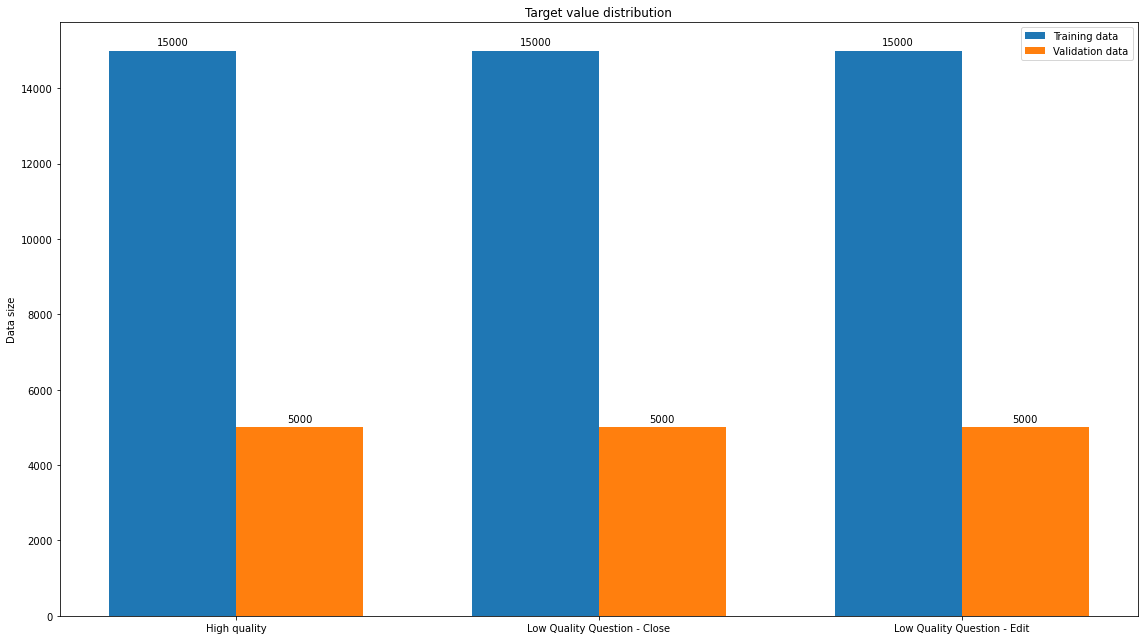

In [4]:
# Create target value distribution-diagram
labels = ['High quality', 'Low Quality Question - Close', 'Low Quality Question - Edit']
values = [len(data[data['Y'] == 2]), len(data[data['Y'] == 0]), len(data[data['Y'] == 1])]
valid_values = [len(valid[valid['Y'] == 2]), len(valid[valid['Y'] == 0]), len(valid[valid['Y'] == 1])]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(16,9))
fig.patch.set_facecolor('white')
rects1 = ax.bar(x - width/2, values, width, label='Training data')
rects2 = ax.bar(x + width/2, valid_values, width, label='Validation data')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Data size')
ax.set_title('Target value distribution')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()
fig.savefig('target_value.pdf')

The question body contains a lot of HTML-tags which do not bring any context into whether a question is good or not, so a cleaning-function is applied to remove all HTML-tags with the content inside of it. Special characters are changed to whitespace as to keep the text clean and separated for use in the vectorizer. 

After some trial and error, it was found that removing the HTML-tags gave worse results than just removing the special characters < and >, so the cleaning-function had to be changed. 

The column containing tags had a format of &lt;Tag1>&lt;Tag2>, which meant that cleaning the data ended with replacing '><' with a whitespace and removing < and >.

In [5]:
# Regex-strings to remove HTML-tags and other symbols not associated with text or code.
def clean_data(text):
    text = text.lower()
    # text = re.sub(r'<[^>]*>',' ', text)
    text = re.sub(r'[^(a-zA-Z0-9)\s]','', text)
    return text

In [6]:
# Remove <, > and ><
def clean_tags(text):
    text = text.lower()
    text = re.sub(r'><',' ', text)
    text = re.sub(r'[<>]','', text)
    return text

## Functions
Before diving into the models themselves, there is a need to create some functions that can be applied across multiple models to keep the results consistent and enable a more functional and clean approach in general. 

### K-fold cross-validation
The k_fold_datasets-function is used to create training and validation datasets from the original training dataset, and returns train_x and valid_x containing the column specified with parameter key, otherwise the returned train_x and valid_x contains the parameters contained in keys. A clean-function is applied if clean=True, which is meant to remove special characters that might skew the results from the vectorizer. 

The amount of parameters passed is a result of keeping the function as general as possible to handle both input with text and input with predicted classes.

In [7]:
# Function to return training and validation sets based on k-fold cross validation
# n defines the iteration number (n>0 and n<=k)
# key defines which column to classify based on
# keys defines the different columns present in the data
# clean_fn defines the function to clean the input
def k_fold_datasets(n,data,k, key, keys, clean_fn, clean=True):
    assert n>0
    size = len(data)
    # Make sure that no single questions are left outside of dataset
    assert size//k == size/k
    lower = int(size/k)*(n-1)
    upper = int(size/k)*n
    # Training Sets
    train = pd.concat([data[:lower],data[upper:]], keys=keys)
    if clean:
        trainX = train[key].apply(clean_fn)
    else:
        trainX = train.copy().drop(['Y'], axis=1)
    trainY = train['Y'].values

    # Validation Sets
    valid = data[lower:upper]
    if clean:
        validX = valid[key].apply(clean_fn)
    else:
        validX = valid.copy().drop(['Y'], axis=1)
    validY = valid['Y'].values
    
    return trainX, trainY, validX, validY

### Vectorization
The vectorizer used to create a representation of the text in the dataset is a [Term Frequency Inverse Document Frequency (TF-IDF) vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). The theory behind this vectorizer is further explained in the report for the project.

In [8]:
# Key and Keys are used when creating concats of different columns
vectorizer = TfidfVectorizer()
def vectorized_data(data, n, k, key, keys, clean_fn = clean_data):
    trainX, trainY, validX, validY = k_fold_datasets(n, data, k, key, keys, clean_fn)
    
    trainX = vectorizer.fit_transform(trainX)
    validX = vectorizer.transform(validX)
    return trainX, trainY, validX, validY


### Averages and validaton
When tuning hyperparameters the average accuracy is calculated from the accuracy per iteration with k-fold cross-validation. 

The function validated_results_nb uses the provided validation set to calculate the overall score with optimal alpha

In [9]:
def average_nb(nb_model, k, dataset, key="Body", keys=["Title", "Body", "Tags", "Y"]):
    average = 0
    for i in range(1,k+1):
        # Create k-fold training and testing sets
        trainX, trainY, validX, validY = vectorized_data(dataset,i, k, key, keys)
        nb_model.fit(trainX, trainY)
        score = nb_model.score(validX, validY)
        average+=score
    average = average / k
    return average

In [10]:
def validated_results_nb(train, valid, alpha, key):
    trainX = vectorizer.fit_transform(train[key].apply(clean_data))
    trainY = train['Y'].values
    validX = vectorizer.transform(valid[key].apply(clean_data))
    validY = valid['Y'].values
    nb = MultinomialNB(alpha=alpha)
    nb.fit(trainX, trainY)
    score = nb.score(validX, validY)
    return score

## Implementation
As to ensure that results are consistent, the training data is randomized before every full run. This means that within one run the data is the same, but the data set might be randomized between full runs with hyperparameter-tuning, meaning that the optimal value for alpha might vary by a few decimals. 

A list of possible alpha-values is used with grid-search to determine the optimal alpha with a margin of 0.05.

The amount of iterations with k-fold is set to 6.

In [11]:
# Randomize data
data = data.sample(frac=1)
alphas = [x/20 for x in range(1,21)]
k_fold = 6

### Question body, Naive Bayes
Iterate over the alpha-values provided and calculate the average score. Save the highest average score and corresponding alpha for use in validation. 

In [12]:
# Test hyperparameters of NB with only body as predictor
best_average_body = 0
best_alpha_body = -1
for a in alphas:
    nb = MultinomialNB(alpha=a)
    average = average_nb(nb, k_fold, data)
    print("a=%.2f: %.3f" % (a, average))
    if average>best_average_body:
        best_average_body = average
        best_alpha_body = a
print("Best average: %.3f \n Best alpha: %.2f" % (best_average_body, best_alpha_body))

a=0.05: 0.786
a=0.10: 0.787
a=0.15: 0.787
a=0.20: 0.786
a=0.25: 0.786
a=0.30: 0.785
a=0.35: 0.784
a=0.40: 0.784
a=0.45: 0.783
a=0.50: 0.782
a=0.55: 0.781
a=0.60: 0.780
a=0.65: 0.779
a=0.70: 0.778
a=0.75: 0.777
a=0.80: 0.777
a=0.85: 0.777
a=0.90: 0.776
a=0.95: 0.775
a=1.00: 0.775
Best average: 0.787 
 Best alpha: 0.10


### Question Title and Body, Naive Bayes
Same approach as the previous one but with title appended to the question body. 

In [13]:
# Test hyperparameters of NB with body and title as predictor
best_average = 0
best_alpha = -1
for a in alphas:
    nb = MultinomialNB(alpha=a)
    average = average_nb(nb, k_fold, title_body_data, key='text', keys=['text', 'Y'])
    print("a=%.2f: %.3f" % (a, average))
    if average>best_average:
        best_average = average
        best_alpha = a
print("Best average: %.3f \n Best alpha: %.2f" % (best_average, best_alpha))

a=0.05: 0.778
a=0.10: 0.777
a=0.15: 0.774
a=0.20: 0.770
a=0.25: 0.767
a=0.30: 0.765
a=0.35: 0.763
a=0.40: 0.761
a=0.45: 0.759
a=0.50: 0.757
a=0.55: 0.755
a=0.60: 0.754
a=0.65: 0.752
a=0.70: 0.750
a=0.75: 0.749
a=0.80: 0.748
a=0.85: 0.747
a=0.90: 0.745
a=0.95: 0.744
a=1.00: 0.743
Best average: 0.778 
 Best alpha: 0.05


### Validation, Naive Bayes
The two optimal alphas found in the previous two steps are used to train two Naive Bayes-models on the full training set and validated with the provided validation set as to have the same grounds for comparing different models. 

In [14]:
print("Score on validation set with body as predictor and alpha=%.2f: %.3f" 
      % (best_alpha_body, validated_results_nb(data, valid, best_alpha_body, 'Body')))
print("Score on validation set with body and title as predictor and alpha=%.2f: %.3f" 
      % (best_alpha, validated_results_nb(title_body_data, title_body_valid, best_alpha, 'text')))

Score on validation set with body as predictor and alpha=0.10: 0.790
Score on validation set with body and title as predictor and alpha=0.05: 0.790


### Question Title, Body and Tags separately, Naive Bayes and kNN
The best alpha for prediction based on question body is reused to train a Naive Bayes-model, trained on a dataset with a size defined by the parameter 'split', and then used to predict the rest of the dataset and provided validation set. 

In [15]:
nb = MultinomialNB(alpha=best_alpha_body)

def predict_nb(split):
    cols = ["Title", "Body", 'Tags']
    # Corresponding cleaning functions to each column
    clean_fns = [clean_data, clean_data, clean_tags]
    predicted_data = data[:45000//split].copy()
    for i in range(len(cols)):
        trainX, trainY, predictX, predictY = vectorized_data(data, 1, k=split, key=cols[i], keys=["Title", "Body", 'Tags', "Y"], clean_fn = clean_fns[i])
        # Swap predict and train to get smaller than n/2 dataset for NB
        nb.fit(trainX, trainY)
        print("%s: %.3f" % (cols[i], nb.score(predictX, predictY)))
        predicted_data[cols[i]] = nb.predict(predictX)
        predicted_data['Y'] = predictY
    return predicted_data


Function to measure average performance across k-fold cross-validation, used in hyperparameter-tuning. 

In [16]:
def average_knn(knn_model, k, dataset, key="Body", keys=["Title", "Body", "Tags", "Y"]):
    average = 0
    for i in range(1,k+1):
        # Create k-fold training and testing sets
        trainX, trainY, validX, validY = k_fold_datasets(i, dataset, k, key, keys, clean_fn=None, clean=False)
        knn_model.fit(trainX, trainY)
        score = knn_model.score(validX, validY)
        average+=score
    average = average / k
    return average

The split is set to 3, which gives NB 30 000 entries for training and then make prediction on the remaining 15 000 entries.

The format of the prediction done by NB is shown below when running.

In [17]:
split=3
print("Predicted data accuracy:")
predicted_data = predict_nb(split)
predicted_data.head()

Predicted data accuracy:
Title: 0.601
Body: 0.785
Tags: 0.582


,Title,Body,Tags,Y
32994,2,2,2,2
35552,1,1,0,1
1497,0,0,1,1
954,2,2,0,2
36894,1,1,2,1


The variable k_list contain the different values for k, and is a combination of arbitrarily chosen numbers and functions based on the size of the dataset. 

All possible k-values in k_list is iterated over and the average score from k-fold cross-validation is calculated. Best k is saved for use in validation. 

In [18]:
pred_size = int(len(predicted_data)*(k_fold-1)/k_fold)
k_list = [1, 10, 100, int(np.log(pred_size)), 
          int(np.sqrt(pred_size)), int(pred_size/2), 
          pred_size]
print(k_list)

print("kNN hyperparameters accuracy:")
best_average_knn = 0
best_k_knn = -1
for k_param in k_list:
    knn = KNeighborsClassifier(n_neighbors=k_param, p=2)
    average = average_knn(knn, k_fold, predicted_data)
    print("k=%d: %.3f" % (k_param, average))
    if average>best_average_knn:
        best_average_knn = average
        best_k_knn = k_param
print("Best average: %.3f \n Best k: %d" % (best_average_knn, best_k_knn))


[1, 10, 100, 9, 111, 6250, 12500]
kNN hyperparameters accuracy:
k=1: 0.711
k=10: 0.785
k=100: 0.795
k=9: 0.787
k=111: 0.795
k=6250: 0.614
k=12500: 0.339
Best average: 0.795 
 Best k: 111


### Validation, NB and kNN
The final code-block is a bit cluttered, so a step-by-step description of the purpose is provided:
1. Initialization of NB and kNN with optimal hyperparameters from earlier.
2. Split the data in partitions of 30 000 entries for training NB, 15 000 for training kNN based on predictions from NB and provided validation set of 15 000 entries, also for predicting with NB and validating kNN. 
3. Iterate over Title, Body and Tags:
    3.1. Vectorize input data in given column from all three partitions so that NB can handle it. 
    3.2. Train NB on first partition of 30 000 entries on given column
    3.3. Predict training data for kNN and validation data for kNN on given column
4. Train kNN on training data with predictions from NB.
5. Calculate accuracy on validation set with predictions from NB.    

In [19]:
# Validation of knn-model
cols = ["Title", "Body", 'Tags']
nb = MultinomialNB(alpha=best_alpha_body)
knn = KNeighborsClassifier(n_neighbors=best_k_knn, p=2)
# Corresponding cleaning functions to each column
clean_fns = [clean_data, clean_data, clean_tags]
training_data = data[15000:].copy()
predicted_data = data[:15000].copy()
predicted_valid = valid.copy()
for i in range(len(cols)):
    trainX = vectorizer.fit_transform(training_data[cols[i]].apply(clean_fns[i]))
    trainY = training_data['Y'].values
    predictX = vectorizer.transform(predicted_data[cols[i]].apply(clean_fns[i]))
    predictY = predicted_data['Y'].values
    validX = vectorizer.transform(predicted_valid[cols[i]].apply(clean_fns[i]))
    validY = predicted_valid['Y'].values
    nb.fit(trainX, trainY)
    predicted_data[cols[i]] = nb.predict(predictX)
    predicted_data['Y'] = predictY
    predicted_valid[cols[i]] = nb.predict(validX)
    predicted_valid['Y'] = validY
    print("%s: %.3f" % (cols[i], nb.score(validX, validY)))
knn.fit(predicted_data.drop(['Y'], axis=1),predicted_data.drop(['Body', 'Title', 'Tags'], axis=1))
score = knn.score(predicted_valid.drop(['Y'], axis=1), predicted_valid.drop(['Body', 'Title', 'Tags'], axis=1))
print(score)

Title: 0.605
Body: 0.783
Tags: 0.583


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.7934666666666667
